In [1]:
#   compare two worlds with cca


# note - look into unit circle normalization assumption more deeply




In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA
import networkx as nx

import hdbscan
import umap

import time
import random
import re

import spacy
from gensim.models import Word2Vec

from pmids2vec import pmids2vec
from pmids2corpus import pmids2corpus

from sklearn.cross_decomposition import CCA
import scipy as sp


In [3]:
### load in 2 word2vec models trained on a coarse cluster

In [4]:
# temp, recreate the list of file names without re-training the w2v models

#model_names = ['data_processing/cluster0.model',
#        'data_processing/cluster1.model',
#        'data_processing/cluster2.model']


### pick just 2 models
model_names = ['data_processing/cluster1.model',
        'data_processing/cluster2.model']

short_names = []

print(model_names)
print()

models = {}

for model_name in model_names:
    
    short_name = str.split(model_name,'/')[-1]
    short_names.append(short_name)
    print(short_name)
    
    model = Word2Vec.load(model_name)
    models[short_name] = model
    print('{} words '.format(len(model.wv.vocab)))  # length of the vocab dict
    print()
    
    
#  ~16,000 words across all 3 clusters (> 25 times)
#  ~3,000 words occurring in all 3 clusters (> 25 times)
#  window size 15

['data_processing/cluster1.model', 'data_processing/cluster2.model']

cluster1.model
5275 words 

cluster2.model
10261 words 



### get shared vocabulary

In [5]:
shared_vocabulary = {}

for i_model, model_name in enumerate(model_names):    
    short_name = str.split(model_name,'/')[-1]
    
    this_vocab = set(models[short_name].wv.vocab)
    
    if i_model==0:
        shared_vocabulary = this_vocab
    elif i_model==1:
        shared_vocabulary = shared_vocabulary.intersection(this_vocab)
        shared_vocabulary = list(shared_vocabulary)
        
print("size of shared vocabulary: {}".format(len(shared_vocabulary)))

size of shared vocabulary: 3520


### build embedding sample matrices

In [6]:
samples = {}
for model_name in model_names:
    
    short_name = str.split(model_name,'/')[-1]
    print(short_name)
    
    D = np.shape(models[short_name].wv['data'])[0] # dimensionality of a sample word, any word will do
    print("number of dimensions D: {}".format(D))
    
    embedding_samples = np.zeros( (len(shared_vocabulary), D) )
    
    # collect samples  (just take every point since these aren't too big)
    for i_word, word in enumerate(shared_vocabulary):
        embedding_samples[i_word,:] = models[short_name].wv[word]
        
    # demean
    '''
    for i_word, word in enumerate(shared_vocabulary):
        embedding_samples[i_word,:] -= np.mean(embedding_samples,0)
    
    # normalize all vectors to the hypersphere
    for i_row,row in enumerate(embedding_samples):
        embedding_samples[i_row,:] /= np.linalg.norm(row,2)
    '''
    
    samples[short_name] = embedding_samples

cluster1.model
number of dimensions D: 25
cluster2.model
number of dimensions D: 25


In [7]:
### visualize before alignment

(3520, 25)
(3520, 25)


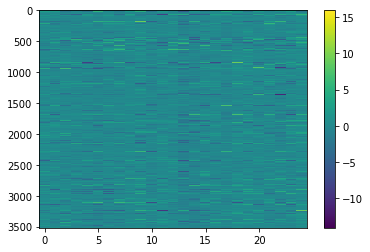

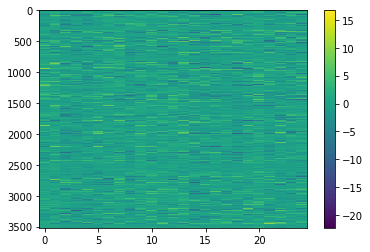

In [8]:

for sample_name,sample_matrix in samples.items():
    
    print(np.shape(sample_matrix))
        
    plt.figure()
    plt.imshow(sample_matrix,aspect='auto')
    plt.colorbar()

In [9]:
### use cca to align the two spaces

(3520, 25)
(25, 25)
(3520, 3)
(3520, 3)
(3,)


Text(0.5, 1.0, 'canonical correlations')

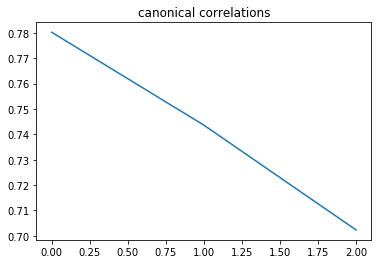

In [65]:


U = samples[short_names[0]]
V = samples[short_names[1]]
print(np.shape(U))

cca = CCA(n_components=3)
cca.fit(U, V)

print(cca.coef_.shape)                   # (5,5)

U_c, V_c = cca.transform(U, V)

print(U_c.shape)                         # (100,1)
print(V_c.shape)                         # (100,1)

# distribution of canonical correlations
cc_corr = np.corrcoef(cca.x_scores_,
                      cca.y_scores_,
                      rowvar=False).diagonal(offset=cca.n_components)
print(np.shape(cc_corr))

plt.figure()
plt.plot(cc_corr)
plt.title('canonical correlations')

In [11]:
### visualize the spaces after alignment

(3520, 3)


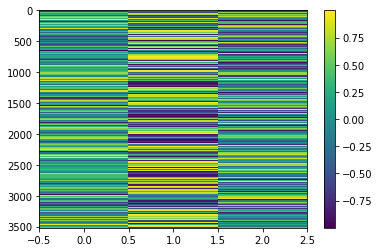

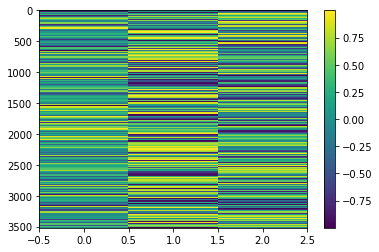

In [66]:
print(np.shape(U_c))

doNorm = True
if doNorm:
    for i_row, row in enumerate(U_c):
        U_c[i_row,:] = row / np.linalg.norm(row)
    for i_row, row in enumerate(V_c):
        V_c[i_row,:] = row / np.linalg.norm(row)


plt.figure()
plt.imshow(U_c, aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(V_c, aspect='auto')
plt.colorbar()

In [13]:
### find most similar and most dissimilar words

most similar
[('reproductive', 43), ('removed', 75), ('facilitates', 108), ('confirmed', 130), ('challenges', 148), ('can', 202), ('correlation', 239), ('current', 336), ('contributed', 339), ('cdc', 381), ('it', 406), ('fbs', 407), ('forming', 423), ('does', 433), ('has', 447), ('consecutive', 520), ('studied', 653), ('identifies', 756), ('syndrome', 1002), ('however', 1020), ('associated', 1026), ('urgently', 1047), ('had', 1054), ('may', 1096), ('organ', 1222), ('towards', 1266), ('have', 1293), ('counts', 1418), ('overview', 1430), ('ld', 1495), ('immunotherapy', 1508), ('that', 1518), ('cancer', 1580), ('onset', 1796), ('_number_', 1830), ('might', 1991), ('vd', 2105), ('glucose', 2158), ('found', 2267), ('shown', 2408), ('forward', 2434), ('ps', 2446), ('less', 2453), ('could', 2561), ('spectrum', 2572), ('why', 2623), ('was', 2654), ('contribution', 2672), ('were', 2757), ('investigated', 2813), ('mesenteric', 2865), ('satellite', 2866), ('plays', 2879), ('idiopathic', 2909), ('

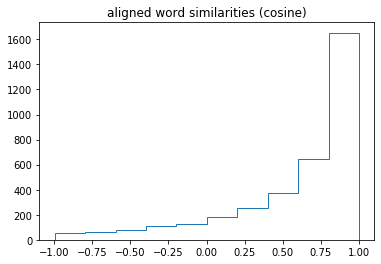

In [67]:
similarities = []
for i_word, word in enumerate(shared_vocabulary):
    
    # check norms (why does CCA not produce unit vectors)
    #print(np.linalg.norm(U_c[i_word]))  #  4.7
    #print(np.linalg.norm(V_c[i_word]))  #  5.4
    
    score = 1 - sp.spatial.distance.cosine(U_c[i_word], V_c[i_word])
    similarities.append(score)    

plt.figure()
plt.hist(similarities, histtype='step')
plt.title('aligned word similarities (cosine)')

high_cutoff = np.percentile(similarities, 98)
low_cutoff = np.percentile(similarities, 2)

most_similar_words = []
least_similar_words = []
for i_word, word in enumerate(shared_vocabulary):
    if similarities[i_word] >= high_cutoff:
        most_similar_words.append( (word, i_word) )
    
    elif similarities[i_word] <= low_cutoff:
        least_similar_words.append( (word, i_word) )
        
print('most similar')
print(most_similar_words)
print()
print('least similar')
print(least_similar_words)

# todo distinguish based on direction of difference

### experiment with umap (only for 1 cluster)

In [68]:
#sphere_mapper = umap.UMAP(output_metric='euclidean',random_state=42).fit(samples[short_names[0]])

reducer = umap.UMAP(output_metric='hyperboloid',
                    n_components=2,
                    metric='cosine')
um = reducer.fit_transform(samples[short_names[0]])

Text(0.5, 0.92, 'testing compression of a single world')

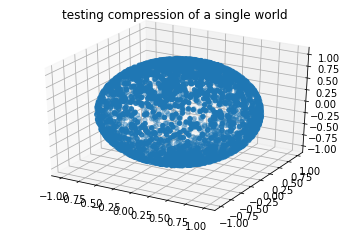

In [69]:
from mpl_toolkits import mplot3d

x = np.sin(um[:,0]) * np.cos(um[:,1])
y = np.sin(um[:,0]) * np.sin(um[:,1])
z = np.cos(um[:,0])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)  # https://umap-learn.readthedocs.io/en/latest/embedding_space.html#plane-embeddings
ax.set_title('testing compression of a single world')

Text(0.5, 1.0, 'testing compression of a single world')

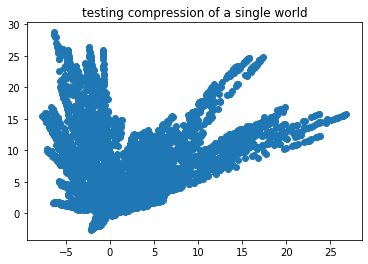

In [70]:
fig = plt.figure()
plt.scatter(um[:,0], um[:,1])
plt.title('testing compression of a single world')

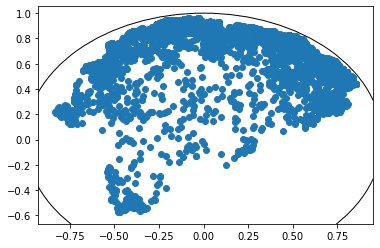

In [71]:
# map to the poincare disk model

z = np.sqrt(1 + np.sum(reducer.embedding_**2, axis=1))
disk_x = um[:,0] / (1 + z)
disk_y = um[:,1] / (1 + z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(disk_x, disk_y)
boundary = plt.Circle((0,0), 1, fc='none', ec='k')
ax.add_artist(boundary)
ax.axis('on');


## merge the two clusters and compare with umap

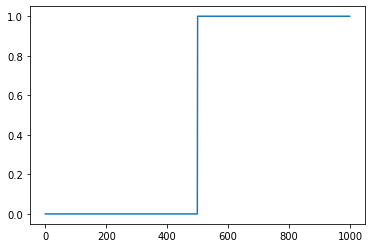

In [72]:
k_truncate = 500
world_1 = samples[short_names[0]][:k_truncate]
world_2 = samples[short_names[1]][:k_truncate]
merged_worlds = np.vstack((world_1, world_2))

world_labels = np.zeros( (1,len(merged_worlds)))
world_labels = world_labels.flatten()
world_labels[len(world_1):] = 1
plt.plot(world_labels)

reducer = umap.UMAP(output_metric='hyperboloid',
                    n_components=2,
                    metric='cosine')
um = reducer.fit_transform(merged_worlds)

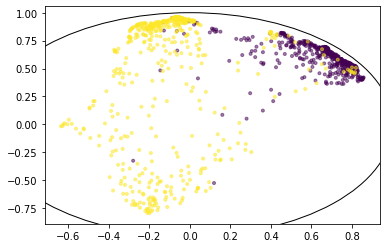

In [73]:
z = np.sqrt(1 + np.sum(reducer.embedding_**2, axis=1))
disk_x = um[:,0] / (1 + z)
disk_y = um[:,1] / (1 + z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(disk_x, disk_y,
           c=world_labels, cmap='viridis',
           marker='.',
           alpha=0.5)
boundary = plt.Circle((0,0), 1, fc='none', ec='k')
ax.add_artist(boundary)
ax.axis('on');



## experiment with visualizing cc's more directly

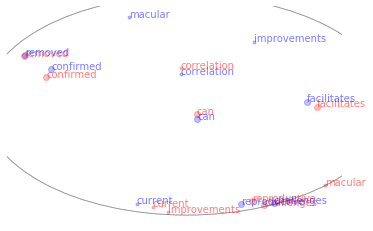

In [75]:
sample_idxs = [most_similar_words[0][1],
               most_similar_words[1][1],
               most_similar_words[2][1],
               most_similar_words[3][1],
               most_similar_words[4][1],
               most_similar_words[5][1],
               most_similar_words[6][1],
               most_similar_words[7][1],
               least_similar_words[3][1],
               least_similar_words[10][1]]
similarity_key = [1,1,1,1,1,1,0,0,0,0,0,0,0]
# sanity check:
'''
for i, v in enumerate(sample_idxs):    
    plt.figure()
    merged = np.vstack( (U_c[v,:], V_c[v,:]) )
    plt.imshow(merged, aspect='auto')
'''

plt.figure()
dim1 = 0
dim2 = 1
for i,v in enumerate(sample_idxs):
    
    if similarity_key[i]:
        marker_ = 'o'
    else:
        marker_ = '.'
        
    plt.scatter(U_c[v, dim1], U_c[v, dim2],
                color='r', marker=marker_,
                alpha=0.25)
    plt.text(U_c[v, dim1], U_c[v, dim2],
             s=shared_vocabulary[v],
             color='r',alpha=0.5)

    plt.scatter(V_c[v, dim1], V_c[v, dim2],
                color='b', marker=marker_,
                alpha=0.25)
    plt.text(V_c[v, dim1], V_c[v, dim2],
             s=shared_vocabulary[v],
             color='b',alpha=0.5)
    
    boundary = plt.Circle((0,0), 1, fc='none', ec='k',alpha=0.05)
    plt.gca().add_artist(boundary)
    plt.gca().axis('off')


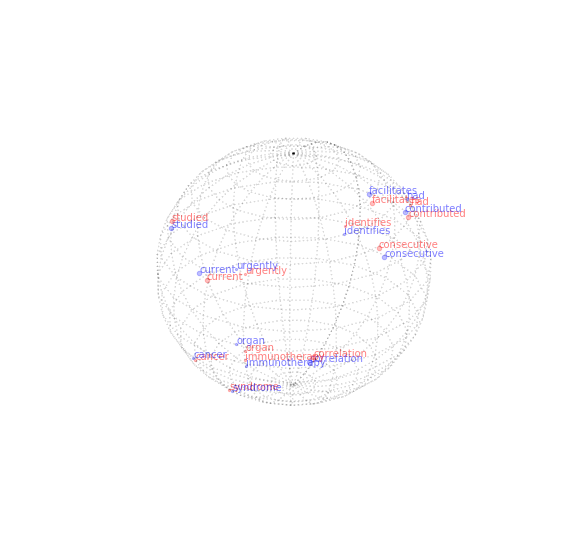

In [181]:
sample_idxs = [most_similar_words[2][1],
               most_similar_words[6][1],
               most_similar_words[7][1], 
               most_similar_words[8][1],
               most_similar_words[15][1],
            most_similar_words[16][1],
            most_similar_words[17][1],
            most_similar_words[18][1],       
              most_similar_words[21][1],     
              most_similar_words[22][1],
            most_similar_words[24][1],
              most_similar_words[30][1],
               
              most_similar_words[32][1]]
similarity_key = [1,1,1,1,1,1,0,0,0,0,0,0,0]
# sanity check:
'''
for i, v in enumerate(sample_idxs):    
    plt.figure()
    merged = np.vstack( (U_c[v,:], V_c[v,:]) )
    plt.imshow(merged, aspect='auto')
'''

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
dim1 = 0
dim2 = 1
dim3 = 2
for i,v in enumerate(sample_idxs):
    
    if similarity_key[i]:
        marker_ = 'o'
    else:
        marker_ = '.'
        
    ax.scatter(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
                color='r', marker=marker_,
                alpha=0.25)
    ax.text(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
             s=shared_vocabulary[v],
             color='r',alpha=0.5)

    ax.scatter(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
                color='b', marker=marker_,
                alpha=0.25)
    ax.text(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
             s=shared_vocabulary[v],
             color='b',alpha=0.5)
    
    #boundary = plt.Circle((0,0), 1, fc='none', ec='k',alpha=0.05)
    #plt.gca().add_artist(boundary)
    #plt.gca().axis('off')
    
    u = np.linspace(0, np.pi, 20)
    v = np.linspace(0, 2 * np.pi, 20)

    x = np.outer(np.sin(u), np.sin(v))
    y = np.outer(np.sin(u), np.cos(v))
    z = np.outer(np.cos(u), np.ones_like(v))

    ax.plot_wireframe(x, y, z,
                    color='k',
                    linestyle=':',
                    alpha=0.01)

    ax.axis('off')

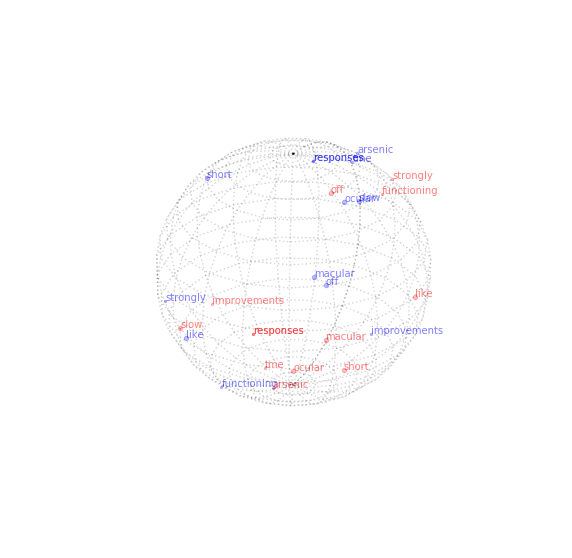

In [185]:
sample_idxs = [least_similar_words[1][1],
               least_similar_words[2][1],
               least_similar_words[3][1],
               least_similar_words[4][1],
               least_similar_words[5][1],
               least_similar_words[6][1],
               least_similar_words[7][1],
               least_similar_words[8][1],
               least_similar_words[8][1],
               least_similar_words[10][1],
               least_similar_words[13][1],
               least_similar_words[14][1],
               least_similar_words[15][1]]
similarity_key = [1,1,1,1,1,1,0,0,0,0,0,0,0]
# sanity check:
'''
for i, v in enumerate(sample_idxs):    
    plt.figure()
    merged = np.vstack( (U_c[v,:], V_c[v,:]) )
    plt.imshow(merged, aspect='auto')
'''

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
dim1 = 0
dim2 = 1
dim3 = 2
for i,v in enumerate(sample_idxs):
    
    if similarity_key[i]:
        marker_ = 'o'
    else:
        marker_ = '.'
        
    ax.scatter(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
                color='r', marker=marker_,
                alpha=0.25)
    ax.text(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
             s=shared_vocabulary[v],
             color='r',alpha=0.5)

    ax.scatter(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
                color='b', marker=marker_,
                alpha=0.25)
    ax.text(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
             s=shared_vocabulary[v],
             color='b',alpha=0.5)
    
    #boundary = plt.Circle((0,0), 1, fc='none', ec='k',alpha=0.05)
    #plt.gca().add_artist(boundary)
    #plt.gca().axis('off')
    
    u = np.linspace(0, np.pi, 20)
    v = np.linspace(0, 2 * np.pi, 20)

    eps = 0.000001
    x = np.outer(np.sin(u), np.sin(v)) - eps
    y = np.outer(np.sin(u), np.cos(v)) - eps
    z = np.outer(np.cos(u), np.ones_like(v)) - eps

    ax.plot_wireframe(x, y, z,
                    color='k',
                    linestyle=':',
                    alpha=0.01)

    ax.axis('off')